<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [1]:
!pip install transformers

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [3]:
!pip install datasets

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoConfig, AutoTokenizer
import evaluate
from transformers import TrainingArguments, Trainer
import pandas as pd
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union, List
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/datasets/data_problems_translated.csv')

In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
label_encoder = LabelEncoder()
df["labels"] = label_encoder.fit_transform(df["topic"])

In [8]:
df

,problem_text,topic,labels
0,To prove that the sum of the numbers of the ex...,number_theory,5
1,( b) Will the statement of the previous challe...,number_theory,5
2,The quadratic three-member graph with the coef...,polynoms,6
3,Can you draw on the surface of Rubik's cube a ...,combinatorics,0
4,"Dima, who came from Vrunlandia, said that ther...",graphs,3
...,...,...,...
5268,Can the number n! end with the figures of 76.0...,number_theory,5
5269,Find all natural m and n for which m! + 12 = n2.,number_theory,5
5270,"The correct 5,000-column has a 2001 vertebrate...",dirichlet,1
5271,Find the maximum number N for which there are ...,number_theory,5


In [9]:
df.head()

,problem_text,topic,labels
0,To prove that the sum of the numbers of the ex...,number_theory,5
1,( b) Will the statement of the previous challe...,number_theory,5
2,The quadratic three-member graph with the coef...,polynoms,6
3,Can you draw on the surface of Rubik's cube a ...,combinatorics,0
4,"Dima, who came from Vrunlandia, said that ther...",graphs,3


In [10]:
len(df), df['topic'].unique(), len(df['topic'].unique())

(5273,
 array(['number_theory', 'polynoms', 'combinatorics', 'graphs', 'geometry',
        'invariant', 'dirichlet'], dtype=object),
 7)

imbalance between classes: 10.195744680851064


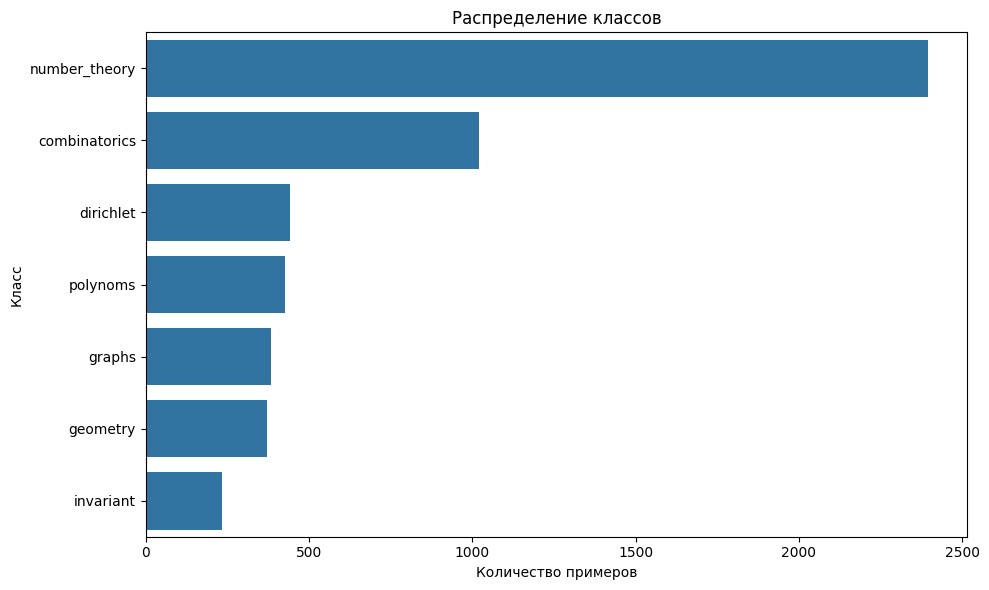

In [11]:
class_counts = df['topic'].value_counts()
imbalance = class_counts.max() / class_counts.min()
print('imbalance between classes:', imbalance)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='topic', order=df['topic'].value_counts().index)
plt.title("Распределение классов")
plt.xlabel("Количество примеров")
plt.ylabel("Класс")
plt.tight_layout()
plt.show()

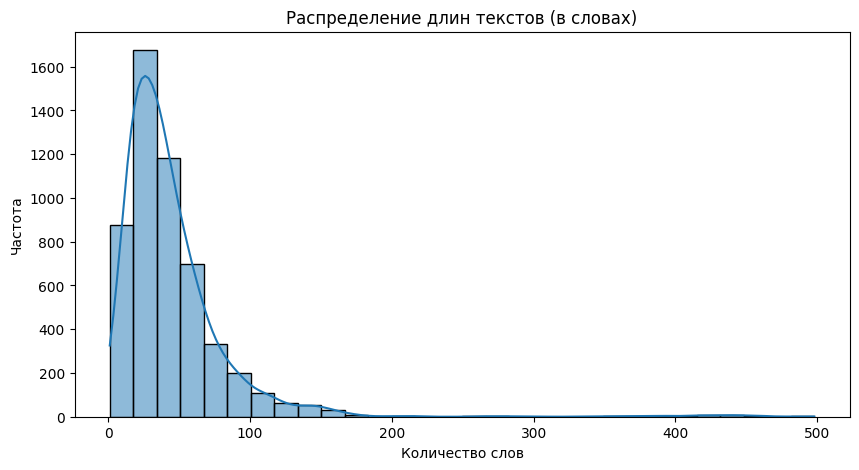

In [12]:
seq_lens = df['problem_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(seq_lens, bins=30, kde=True)
plt.title("Распределение длин текстов (в словах)")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.show()

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [13]:
### This is just an interface example. You may change it if you want.

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes: int):
        super(TransformerClassificationModel, self).__init__()

        if isinstance(base_transformer_model, str):
            self.backbone = AutoModel.from_pretrained(base_transformer_model)
            config = AutoConfig.from_pretrained(base_transformer_model)
            hidden_size = config.hidden_size
        elif isinstance(base_transformer_model, nn.Module):
            self.backbone = base_transformer_model
            hidden_size = self.backbone.config.hidden_size
        else:
            raise ValueError("base_transformer_model must be either a model name string or an nn.Module instance.")

        # YOUR CODE: create additional layers for classification
        self.dropout = nn.Dropout(0.1)
        self.Linear = nn.Linear(hidden_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.lin = nn.Tanh()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
      outputs = self.backbone(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids,
      )

      pooled_output = outputs.last_hidden_state[:, 0]  # CLS токен
      pooled_output = self.dropout(self.lin(self.Linear(pooled_output)))
      logits = self.classifier(pooled_output)

      loss = None
      if labels is not None:
          loss = nn.CrossEntropyLoss()(logits, labels)

      return {"loss": loss, "logits": logits}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [14]:
def freeze_backbone_function(model: TransformerClassificationModel):
    model.backbone.requires_grad_ = False
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [15]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

def tokenize_function(example):
    return tokenizer(example["problem_text"], padding="max_length", truncation=True, max_length=2048)

dataset = Dataset.from_pandas(df[["problem_text", "labels"]])
dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(["problem_text"])
dataset = dataset.train_test_split(test_size=0.1)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/5273 [00:00<?, ? examples/s]

In [17]:
import copy

def train_transformer(transformer_model, freeze_backbone=True):
    model = copy.copy(transformer_model)
    if freeze_backbone:
        model = freeze_backbone_function(model)

    training_args = TrainingArguments(
    output_dir="./results/rubert-tiny2",      # куда сохранять модель и чекпойнты
    overwrite_output_dir=True,                # если уже есть — перезаписать

    eval_strategy="epoch",              # когда считать метрики (в конце каждой эпохи)
    save_strategy="epoch",                    # сохранять модель тоже раз в эпоху
    save_total_limit=2,                       # хранить только 2 последних чекпойнта

    per_device_train_batch_size=8,           # размер батча на одно устройство
    per_device_eval_batch_size=8,
    num_train_epochs=4,                       # сколько эпох

    learning_rate=2e-5,                       # начальный learning rate
    weight_decay=0.01,                        # L2 регуляризация

    logging_dir="./logs",                     # куда писать TensorBoard-логи
    logging_steps=50,                         # как часто логировать в шагах

    load_best_model_at_end=True,              # после обучения загрузить лучшую модель (по метрике)
    metric_for_best_model="accuracy",         # по какой метрике выбирать
    greater_is_better=True,

    fp16=True,                                # ускорение на GPU (если поддерживается)
    report_to="tensorboard",                  # включить TensorBoard логирование
    push_to_hub=False                         # не пушить на HuggingFace Hub
)

    trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    )
    finetuned_model = trainer.train()

    return finetuned_model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [18]:
rubert_tiny_transformer_model = TransformerClassificationModel('cointegrated/rubert-tiny2', 7)
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model, freeze_backbone=True)

rubert_tiny_transformer_model = TransformerClassificationModel('cointegrated/rubert-tiny2', 7)
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model, freeze_backbone=False)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 14.74 GiB of which 968.12 MiB is free. Process 6035 has 13.79 GiB memory in use. Of the allocated memory 12.11 GiB is allocated by PyTorch, and 1.55 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [ ]:
### YOUR CODE IS HERE (probably, similar on the previous step)

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
def draw_first_layer_attention_maps(attention_head_ids: List, text: str, model: TransformerClassificationModel):
    pass

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [ ]:
### YOUR CODE IS HERE

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

In [ ]:
### YOUR CODE IS HERE